In [38]:
import pandas as pd
import numpy as np
import geopandas as geo
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image  
from pydotplus import graph_from_dot_data
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline

from ml_repo import scores
from ml_repo import roc_plot
from ml_repo import annot
from ml_repo import plotfeatures
from ml_repo import print_metrics
from ml_repo import opt_plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
X = pd.read_csv('Data/X.csv')
y = pd.read_csv('Data/Y.csv')
X1 = pd.read_csv('Data/X1.csv')
df = pd.merge(y,X,on='id')

In [3]:
df['installer'].fillna('other', inplace = True)
df['funder'].fillna('other', inplace = True)
df['public_meeting'].fillna('False', inplace = True)
df['scheme_management'].fillna('other',inplace = True)
df['permit'].fillna('False', inplace = True)
df.drop(columns =['recorded_by', 'extraction_type_group','extraction_type_class', 'payment', 'quantity_group', 'source', 'source_class', 'id', 'num_private', 'quantity_group','waterpoint_type_group', 'wpt_name', 'scheme_name', 'amount_tsh'], inplace = True)
df['region_and_code'] = df['region'] + df['region_code'].map(str)
df.drop(columns = ['region', 'region_code'], inplace = True)
df.population.replace(0,df.groupby(['district_code']).population.mean(), inplace = True)
df.status_group.replace('functional needs repair','non functional', inplace = True)

In [4]:
i = df.construction_year.median()
df.construction_year.replace(0,i,inplace=True)

j = df.groupby(['basin']).gps_height.mean()
df.gps_height.replace(0,j, inplace = True)

In [5]:
df['year'] = df.date_recorded.str[:4]
df['month'] = df.date_recorded.str[-4]
df.drop(columns = ['date_recorded'], inplace = True)
df['length_operation'] = df.year.map(int) - df.construction_year.map(int)

In [6]:
cols = [i for i in df.columns if type(df[i].iloc[0]) == str]
df[cols] = df[cols].where(df[cols].apply(lambda x: x.map(x.value_counts())) > 50,"other")

In [7]:
count_class_0, count_class_1 = df.status_group.value_counts()
df_class_0 = df[df['status_group'] == 'functional']
df_class_1 = df[df['status_group'] == 'non functional']
df_class_0_under = df_class_0.sample(count_class_1)
df_balanced = pd.concat([df_class_0_under, df_class_1], axis = 0)

In [8]:
scaler = MinMaxScaler()
conti = df_balanced.loc[:,['population', 'gps_height', 'length_operation']]
df_balanced[['population', 'gps_height', 'length_operation']] = scaler.fit_transform(df_balanced[['population', 'gps_height', 'length_operation']])

In [9]:
y = df_balanced['status_group']

X = df_balanced.loc[:, ['funder', 'gps_height', 'installer',
       'basin', 'subvillage', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source_type', 'waterpoint_type', 'region_and_code', 'year',
       'month', 'length_operation']]

X1 = pd.get_dummies(X, prefix = ['funder', 'installer',
       'basin', 'subvillage', 'district_code', 'lga', 'ward',
       'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source_type', 'waterpoint_type', 'region_and_code'])

y1 = pd.get_dummies(y, prefix = ['status_group'])
y1 = y1.iloc[:,0]
X1.shape

(54282, 926)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42, test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42) 
skf = StratifiedKFold(n_splits=5,random_state=42)

# Logistic Regression

## Baseline

In [11]:
%%time

logreg = LogisticRegression(fit_intercept = False, C = 1e15, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

CPU times: user 9.14 s, sys: 247 ms, total: 9.39 s
Wall time: 9.28 s


LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
train_prob = model_log.predict_proba(X_train)[:,1]
val_prob = model_log.predict_proba(X_val)[:,1]

print ('train accuracy:', model_log.score(X_train, y_train),'//','val accuracy:', model_log.score(X_val, y_val))

train accuracy: 0.7882843983880253 // val accuracy: 0.7810017271157168


train roc_auc: 0.87 val/test roc_auc: 0.86


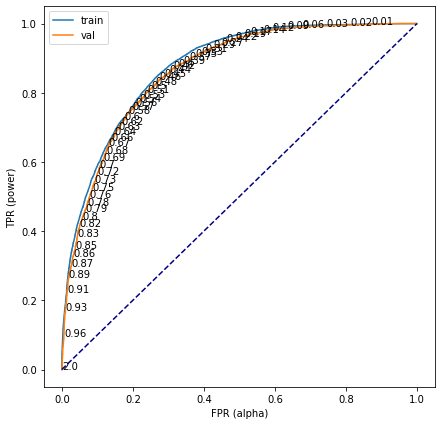

In [13]:
scores(model_log,X_train,X_val,y_train,y_val)
roc_plot(model_log,X_train,y_train,X_val,y_val)

In [14]:
param_grid = [{'C': np.logspace(0,4,10), 'penalty': ['l1','l2'],'solver' : ['lbfgs'],'max_iter' : [10,100,100]}]
    
log_clf = LogisticRegression(class_weight='balanced')

In [15]:
grid_logistic = GridSearchCV(log_clf, param_grid, cv=skf, scoring='roc_auc', return_train_score=True)

In [16]:
grid_logistic.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                          'max_iter': [10, 100, 100], 'penalt

In [17]:
grid_logistic.best_params_
best_log = grid_logistic.best_estimator_
best_log

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
y_log_pred_proba = cross_val_predict(best_log, X_train, y_train,method='predict_proba', cv=skf)[:,1]


In [19]:
roc_auc_log = roc_auc_score(y_train, y_log_pred_proba)
print(roc_auc_log)

0.823245292676076


In [20]:
optimal_model = grid_logistic.best_estimator_

probas = optimal_model.predict_proba(X_train)

y_prob = cross_val_predict(optimal_model, X_train, y_train,method='predict_proba', cv=3)[:,1]
# Obtain our False positive rate and True positive rate as wella s our Thresholds:
fpr,tpr,threshold = roc_curve(y_train, y_prob)

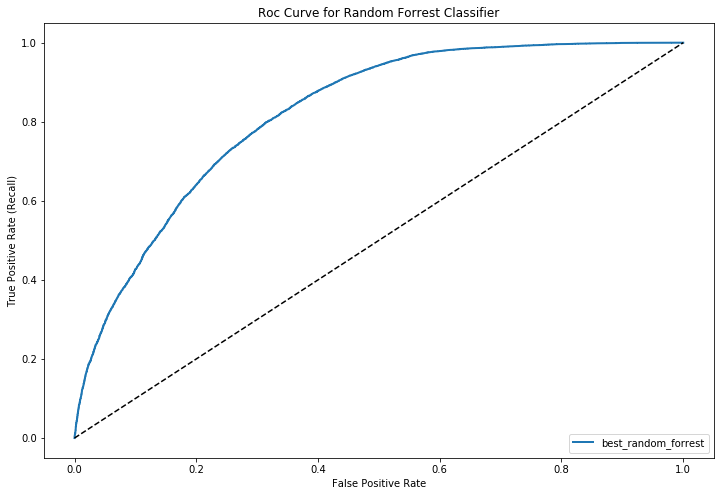

In [21]:

# Obtain our False positive rate and True positive rate as wella s our Thresholds:
fpr,tpr,threshold = roc_curve(y_train, y_prob)
def plot_roc_curve(fpr, tpr, label=None):
    fig = plt.figure(figsize=(12,8))
    plt.plot(fpr,tpr,linewidth= 2, label=label)
    plt.plot([0,1], [0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Roc Curve for Random Forrest Classifier')
    plt.legend(loc=4)

plot_roc_curve(fpr, tpr, label='best_random_forrest')
plt.show()

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig = plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.ylabel("Score")
    plt.title('Precision/Recall Trade-off')
    plt.legend(loc='center right')

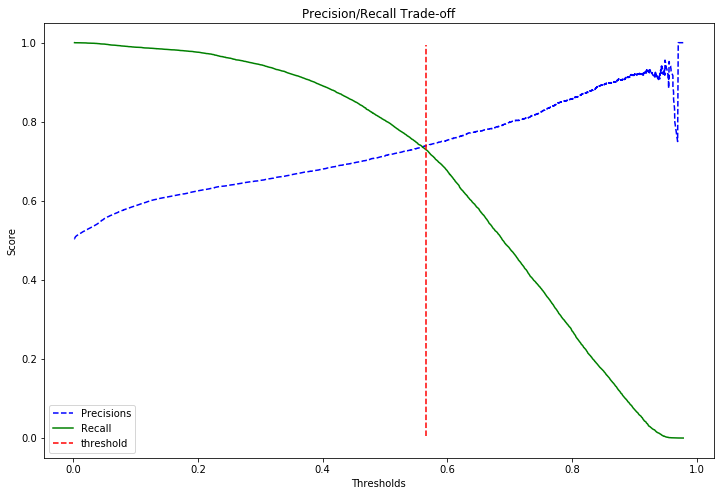

In [23]:
best_threshold = 0.566

precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.axvline(best_threshold, c='red', linestyle='--', label='threshold', ymax=0.95, ymin=0.05)
plt.legend()
plt.show()